In [1]:
import glob
import os
import pandas as pd
import numpy as np
import librosa.display as display
import matplotlib.pyplot as plt
%matplotlib inline

import pretty_midi


from IPython.display import clear_output

# Simplifying the dataset

[We've listed all the instruments present by count](/notebooks/notebooks/Load%20Instruments.ipynb) so we'll build on the work in that notebook, by loading the csv file it has produced.

We will want to only focus on training melodies for one set for now, so it makes sense to pick an instrument (program code), that is present in large quantities, and is likely to have long melodies to train on.

[See here](https://soundprogramming.net/file-formats/general-midi-instrument-list/) for a list of instrument programs and their names.

In [2]:
instruments = pd.read_csv('instruments.csv', sep=';', index_col=0)
instruments.head()

/Users/joachimsvendsen/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,program,is_drum,name,filepath
1,program,is_drum,name,filepath
2,25,True,Rap drumset,"../clean_midi/""Weird Al"" Yankovic/Amish Paradi..."
3,48,False,string 1,"../clean_midi/""Weird Al"" Yankovic/Amish Paradi..."
4,35,False,fretless,"../clean_midi/""Weird Al"" Yankovic/Amish Paradi..."
5,52,False,choir aahs,"../clean_midi/""Weird Al"" Yankovic/Amish Paradi..."


## We'll focus on one of the most popular instruments

Let's list the top used instruments below:

You'll notice the name column has a large count. The name appears to be a free text field for description of the intention of this track in the MIDI file, the program is the instrument used.

Because these midi files are created by humans, there's a risk that people will intend for a track to be a certain type, but have used a program they liked the sound of in their midi engine when creating the track. It is common for vocals to be coded as Strings, (52 Choir Aahs, 53 Voice Oohs), for instance. We're going to disregard this problem for now, and assume the program codes are accurate.

In [3]:
# Show the instrument with the most unique filepath values
grouped = instruments.groupby('program').nunique().sort_values('filepath', ascending=False)
grouped.head(n=10)

,program,is_drum,name,filepath
program,,,,
0,1,2,5879,10827
33,1,2,1288,4447
25,1,2,1612,3963
48,1,2,1373,3937
0,1,2,2207,3385
29,1,2,1419,3296
27,1,2,1266,3210
35,1,2,754,3024
30,1,2,1371,2967


In [4]:
# Translate the program codes to instrument names
for program in grouped.head(n=10).index.values:
    print(pretty_midi.program_to_instrument_name(int(program)))
# 

Acoustic Grand Piano
Electric Bass (finger)
Acoustic Guitar (steel)
String Ensemble 1
Acoustic Grand Piano
Overdriven Guitar
Electric Guitar (clean)
Fretless Bass
Distortion Guitar
Choir Aahs


The top instrument used is 0: Acoustic Grand Piano.

It doesn't seem to be the most realiable program of them all (7281 different plaintext names compared to the next in line with 1588), so it does point towards this being used for a bunch of different stuff.
We'll continue inspecting this.

In [5]:
instruments[(instruments['program'] == 0)].head(n=10)

,program,is_drum,name,filepath
131073,0,True,drums,../clean_midi/Soundgarden/My Wave.mid
131088,0,True,MIDI,../clean_midi/Spandau Ballet/Gold.1.mid
131106,0,True,NaN,../clean_midi/Spandau Ballet/Gold.mid
131111,0,True,Drums,../clean_midi/Spandau Ballet/True.1.mid
131112,0,True,Drums (kick),../clean_midi/Spandau Ballet/True.1.mid
131133,0,False,A.PIANO 1,../clean_midi/Spandau Ballet/True.2.mid
131142,0,True,Drums,../clean_midi/Spandau Ballet/True.3.mid
131143,0,False,Bass Syn,../clean_midi/Spandau Ballet/True.3.mid
131144,0,False,Ac Piano,../clean_midi/Spandau Ballet/True.3.mid
131145,0,False,Guitar,../clean_midi/Spandau Ballet/True.3.mid


Not exactly all pianos.
Let's try to filter for names that contain the word "piano"

In [6]:
pianos = instruments[(instruments['program'] == 0) & (instruments['name'].str.contains('piano', case=False))]
print(len(pianos))
pianos.head(n=10)

671


,program,is_drum,name,filepath
131133,0,False,A.PIANO 1,../clean_midi/Spandau Ballet/True.2.mid
131144,0,False,Ac Piano,../clean_midi/Spandau Ballet/True.3.mid
131205,0,False,A.PIANO 1,../clean_midi/Sparks/When I Kiss You.mid
131240,0,False,#E.Piano,../clean_midi/Spice Girls/2 Become 1.2.mid
131700,0,False,Piano,../clean_midi/Spice Girls/Wannabe.1.mid
131734,0,False,GPiano,../clean_midi/Spice Girls/Who Do You Think You...
131748,0,False,GPiano,../clean_midi/Spice Girls/Who Do You Think You...
131839,0,False,El Piano,../clean_midi/Spyro Gyra/Morning Dance.mid
131860,0,False,PIANO,../clean_midi/Squeeze/Tempted.mid
131891,0,False,A.PIANO 1,../clean_midi/Stan Getz/The Girl From Ipanema ...


Much better.

But now we're reduced to 3183 files. It'll have to do for now.

# Loading all files for the instrument

We'll iterate over our piano list and load all the midi files, get the piano rolls and save the result as a CSV for later consumption.

This will take a few minutes, since parsing takes long in itself.

In [7]:
note_columns = [pretty_midi.note_number_to_name(n) for n in range(0,128)]
def encode_dummies(instrument, sampling_freq):
    """ Gonna cheat a little bit by transposing the instrument piano roll. 
        However, that leaves us with a lot of blank space. 
    """
    return pd.DataFrame(instrument.get_piano_roll(fs=sampling_freq).astype('int').T, columns=note_columns)

def trim_blanks(df):
    """
        Remove the first period of no activity (fast forward to where the first note begins for this instrument)
    """
    nonzero = df.apply(lambda s: s != 0)
    nonzeroes = df[nonzero].apply(pd.Series.first_valid_index)
    first_nonzero = nonzeroes.min()
    if first_nonzero is pd.np.nan:
        return None
    return df.iloc[int(first_nonzero):]

"""
    Create a pandas to store the piano rolls in.
    It'll look a bit like this:
    
    |   Index     | t | C0 |...| C10 |
    |Song_name_3:0| 0 | 40 |...| 0   |
    |             | 1 | 40 |...| 0   |
    |             |...|... |...| ... |
    |             | N | 40 |...| 0   |
    |Song_name_3:1| 0 | 40 |...| 0   |
    |             |...|... |...| ... |
    |             | N | 40 |...| 0   |
    |Song_name_4:0| 0 | 40 |...| 0   |
    |             |...|... |...| ... |
    |             | N | 40 |...| 0   |

"""
saved_columns = [pretty_midi.note_number_to_name(n) for n in range(48,108)]
piano_rolls = pd.DataFrame(columns=['piano_roll_name', 'timestep'] + saved_columns)
piano_rolls = piano_rolls.set_index(['piano_roll_name', 'timestep'])
piano_rolls.head()

,,C3,C#3,D3,D#3,E3,F3,F#3,G3,G#3,A3,...,D7,D#7,E7,F7,F#7,G7,G#7,A7,A#7,B7
piano_roll_name,timestep,,,,,,,,,,,,,,,,,,,,,


In [8]:
# Chops off the upperbound and lowerbound of zeros
# The lower bound note is set a C, which might make it easier
# to make the MIDI play in the same key.
def chopster(dframe):
    # Figure out range of frame (0-128)
    df_max = dframe.max(axis = 0)
    
    dframe.drop(labels=[pretty_midi.note_number_to_name(n) for n in range(108,128)], axis=1, inplace=True)
    dframe.drop(labels=[pretty_midi.note_number_to_name(n) for n in range(0,48)], axis=1, inplace=True)
    return dframe
#     for i in range(len(df_max)-1, 0, -1):
#         if df_max[i] != 0:
#             upper_bound_C = i
#             for j in range(len(df_max)):
#                 if df_max[j] != 0:
#                     lower_bound_C = j-(j%12)
#                     dframe.drop(labels=[pretty_midi.note_number_to_name(n) for n in range(upper_bound_C,128)], axis=1, inplace=True)
#                     dframe.drop(labels=[pretty_midi.note_number_to_name(n) for n in range(0,lower_bound_C)], axis=1, inplace=True)
                    
#                     break
#             break
#     return dframe

# Non-zero values changed to 1's
def minister(dframe):
    return dframe.where(dframe<1, 1)


# Removes chords and turns them into melody
def arpster(dframe):
    # Count amount of notes being played at once.
    note_amount = np.asarray(dframe.astype(bool).sum(axis=1))
    i = 0
    
    # Slide through whole MIDI
    while i < dframe.shape[0]:
        # Check if note is single
        if note_amount[i] == 1:
            i += 1
            continue
        elif note_amount[i] > 1: 
            hits = 0
            hit_index = []
            # Calculates the amount of notes being played
            for j in range(dframe.shape[1]):
                if dframe.iloc[i,j] == 1:
                    hit_index.append(j)
                    hits += 1
                    if hits == note_amount[i]:
                        break

            length = 0
            # Removes all notes such that chords are turned into arpeggios
            while dframe.iloc[i+length, hit_index[length % (hits)]] == 1:
                for k in range(len(hit_index)):
                    if k != (length % hits):
                        dframe.iloc[i+length, hit_index[k]] = 0
                    
                if  note_amount[i+length-1] != note_amount[i+length]:
                    length += 1
                    break
                
                length += 1
                
                if len(note_amount) <= i+length:
                    break
            
            # Skip ahead to next note
            i += length
                
        # Maybe a case where we count ithe amount of silent steps going ahead
        elif note_amount[i] == 0:
            i += 1
            continue
        
    return dframe

# Chops up into desired window size.
# and maybe saves them to csv in this step?
# frame_size: amount of measures pr input
def cutster(dframe, frame_size, undesired_silence):
    # Chop up if the window size fits the music
    
    # Check if frame size is greater than MIDI length
    # Pad with zeros
    if frame_size > dframe.shape[0]/16:
        return dframe
    
    note_amount = np.asarray(dframe.astype(bool).sum(axis=1))
    zero_amount = 0
    
    df_dictionary = {}
    dict_index = 0
    
    divider = 0
    i = 0
    while i < len(note_amount):
        # Cuts out silent measures if greater than undesired_silence
        if zero_amount/16 > undesired_silence and note_amount[i] != 0:
            drop_amount = [j for j in range(i-zero_amount,i)]
            dframe.drop(drop_amount, inplace=True)
            note_amount = np.delete(note_amount, drop_amount)
            i -= zero_amount-1
            zero_amount = 0
            
        # Seperates MIDI in desired chunks 
        elif (i-divider)/16 == frame_size:
            df_dictionary[str(dict_index)] = dframe.iloc[divider:i+1]
            dict_index += 1
            divider = i+1
            zero_amount = 0
            i += 1
        elif note_amount[i] != 0:
            if zero_amount != 0:
                zero_amount = 0
            i += 1
        # Count sequential zeros
        elif note_amount[i] == 0:
            zero_amount += 1
            i += 1
        
    return df_dictionary

# Add desired amount of padding to 
# all MIDI files such that they contain 
# the same amount of dimensions.
def padster(dframe):
    # Find MIDI piece with most keys used
    # Pad all others such they fit the dimensions
    return dframe.fillna(0)
    
    

In [9]:
# DISCLAIMER:
# This file is inspired by Nick Kelly by his article on tranposing MIDI files.
# http://nickkellyresearch.com/python-script-transpose-midi-files-c-minor/

import glob
import os
import music21

# Transpose MIDI to same key (C major or A minor)
def transposer(midi_file):
    midi_array = midi_file.split('/')

    # converting everything into the key of C major or A minor
    # Major conversion
    majors = dict([("A-", 4),("G#", 4),("A", 3),("A#", 2),("B-", 2),("B", 1),("C", 0),("C#", -1),("D-", -1),("D", -2),("D#", -3),("E-", -3),("E", -4),("F", -5),("F#", 6),("G-", 6),("G", 5)])
    # Minor conversion
    minors = dict([("G#", 1), ("A-", 1),("A", 0),("A#", -1),("B-", -1),("B", -2),("C", -3),("C#", -4),("D-", -4),("D", -5),("D#", 6),("E-", 6),("E", 5),("F", 4),("F#", 3),("G-", 3),("G", 2)])

    score = music21.converter.parse(midi_file)
    key = score.analyze('key')
    if key.mode == "major":
        halfSteps = majors[key.tonic.name]

    elif key.mode == "minor":
        halfSteps = minors[key.tonic.name]

    return halfSteps

# Parsing the data to csv

The following step takes too long and is projected to take up roughly 30gb of space - so let's do some more splitting work on it (to reduce breaks between segments). Maybe consider cutting away large parts of the tonal range, such as only using songs where the instruments are between C4 and C8 or something.

Alternatively, we can load in the files directly during training in a data loader, but I'd like to clean and split the songs beforehand so they're easier to train on.

We could split all the songs into x-bar segments and save them as .mid files in a processed folder. Should take up less space and be easier.

In [14]:
limit = 1

file_name = 'piano_rolls.csv'
piano_rolls.to_csv(file_name, sep=';', encoding='utf-8')

# This might take a while...
for i, file in enumerate(pianos['filepath'][:limit]):
    clear_output(wait=True)
    song_name = os.path.basename(file)
    print("{}/{}: Loading and parsing {}.".format(i, len(pianos), song_name))
    try:
        semi_shift = transposer(file)
        pm = pretty_midi.PrettyMIDI(file)
        """
            Here we calculate the amount of seconds per sixteenth note, by taking the second beat of the song 
            (which is the same as the difference in seconds between the first and second beat),
            and convert it to the sampling frequency format that pretty_midi expects.
        """
        sampling_freq = 1/ (pm.get_beats()[1]/4)
    except:
        # For now, just ignore files we can't load.
        continue
    for j, instrument in enumerate(pm.instruments):
        # Hardcoded for now:
        if instrument.program == 0 and 'piano' in instrument.name.lower():
            """
                Generate a unique top level index per song and instrument in this song,
                if it has multiples of the same kind.
            """
            for note in instrument.notes:
                note.pitch += semi_shift
            top_level_index = "{}_{}:{}".format(song_name, i, j)

            df = encode_dummies(instrument, sampling_freq).fillna(value=0) # Fill invalid values
            df = trim_blanks(df)
            if df is None:
                # We've got an empty track
                continue
            df['timestep'] = df.index
            df['piano_roll_name'] = top_level_index
            df = df.set_index(['piano_roll_name', 'timestep'])
            df = minister(df)
            df = chopster(df)
            df = arpster(df)
            new_df = cutster(df, 8, 10000)

            for dframe in new_df:
                top_level_index = "{}_{}:{}".format(song_name, i, j)
                dframe.to_csv(file_name, sep=';', mode='a', encoding='utf-8', header=False)
            

0/671: Loading and parsing True.2.mid.


AttributeError: 'str' object has no attribute 'to_csv'

(1175, 60)


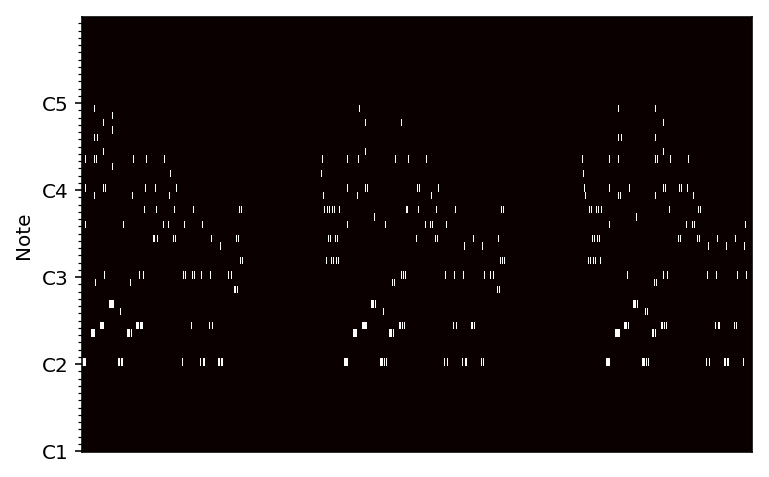

In [13]:
rolls = pd.read_csv("piano_rolls.csv", sep=';', index_col=['piano_roll_name', 'timestep'])
rolls.head()
print(rolls.shape)
#rolls = padster(rolls)
first = rolls.loc['True.2.mid_0:0'].T
display.specshow(first.values, y_axis='cqt_note', cmap=plt.cm.hot)

In [ ]:
rolls = rolls.loc[:, (rolls != 0).any(axis=0)]
rolls.tail(n=16)